In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tic_env import TictactoeEnv, OptimalPlayer
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%matplotlib inline

# Tic Toc Toe environment

Our 1st game is the famous Tic Toc Toe. You can read about the game and its rules here: https://en.wikipedia.org/wiki/Tic-tac-toe

We implemented the game as an environment in the style of games in the [Python GYM library](https://gym.openai.com/). The commented source code is available in the file "tic_env.py". Here, we give a brief introduction to the environment and how it can be used.

### Initialization and attributes

You can initialize the environment / game as following:

In [10]:
env = TictactoeEnv()

Which then has the following attributes with the corresponding initial values:

In [11]:
env.__dict__

{'grid': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 0,
 'current_player': 'X'}

The game is played by two players: player 'X' and player 'O'. The attribute 'current_player' shows whose turn it is. We assume that player 'X' always plays first.

The attribute 'grid' is a 3x3 numpy array and presents the board in the real game and the state $s_t$ in the reinfocement learning language. Each elements can take a value in {0, 1, -1}:
     0 : place unmarked
     1 : place marked with X 
    -1 : place marked with O 
        
The attribute 'end' shows if the game is over or not, and the attribute 'winner' shows the winner of the game: either "X", "O", or None.  

You can use function 'render' to visualize the current position of the board:

In [12]:
env.render()

|- - -|
|- - -|
|- - -|



### Taking actions

The game environment will recieve action from two players in turn and update the grid. At each time, one player can take the action $a_t$, where $a_t$ can either be an integer between 0 to 8 or a touple, corresponding to the 9 possible.

Function 'step' is used to recieve the action of the player, update the grid:

In [13]:
env.step(2)

(array([[0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 False,
 None)

In [14]:
env.render()

|- - X|
|- - -|
|- - -|



In [15]:
env.__dict__

{'grid': array([[0., 0., 1.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 1,
 'current_player': 'O'}

In [16]:
env.step((1,1))

(array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 False,
 None)

In [17]:
env.render()

|- - X|
|- O -|
|- - -|



In [18]:
env.__dict__

{'grid': array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 'end': False,
 'winner': None,
 'player2value': {'X': 1, 'O': -1},
 'num_step': 2,
 'current_player': 'X'}

But not all actions are available at each time: One cannot choose a place which has been taken before. There is an error if an unavailable action is taken:

In [19]:
env.step((0,2))

ValueError: There is already a chess on position (0, 2).

### Reward

Reward is always 0 until the end of the game. When the game is over, the reward is 1 if you win the game, -1 if you lose, and 0 besides. Function 'observe' can be used after each step to recieve the new state $s_t$, whether the game is over, and the winner, and function 'reward' to get the reward value $r_t$:

In [ ]:
env.observe()

(array([[ 0.,  0.,  1.],
        [ 0., -1.,  0.],
        [ 0.,  0.,  0.]]),
 False,
 None)

In [ ]:
env.reward(player='X')

0

In [ ]:
env.reward(player='O')

0

An example of finishing the game:

In [ ]:
env.step(0)
env.step(3)
env.step(1)

(array([[ 1.,  1.,  1.],
        [-1., -1.,  0.],
        [ 0.,  0.,  0.]]),
 True,
 'X')

In [ ]:
env.render()

|X X X|
|O O -|
|- - -|



In [ ]:
env.observe()

(array([[ 1.,  1.,  1.],
        [-1., -1.,  0.],
        [ 0.,  0.,  0.]]),
 True,
 'X')

In [ ]:
env.reward(player='X')

1

In [ ]:
env.reward(player='O')

-1

# Optimal policy for Tic Toc Toe environment

Fortunately, we know the exact optimal policy for Tic Toc Toe. We have implemented and $\epsilon$-greedy version of optimal polciy which you can use for the project.

In [ ]:
env.reset();

In [ ]:
opt_player = OptimalPlayer(epsilon = 0., player = 'X')

In [ ]:
opt_player.act(env.grid)

(0, 0)

In [ ]:
opt_player.player

'X'

### An example of optimal player playing against random player

In [ ]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt = OptimalPlayer(epsilon=0., player=Turns[0])
    player_rnd = OptimalPlayer(epsilon=1., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt.act(grid)
        else:
            move = player_rnd.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player = ' +  Turns[0])
            print('Random player = ' +  Turns[1])
            env.render()
            env.reset()
            break


-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|- - X|
|O X -|
|X O -|

-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|O O X|
|- X X|
|O - X|

-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|O X X|
|O O X|
|X O X|

-------------------------------------------
Game end, winner is player O
Optimal player = O
Random player = X
|O - -|
|X O X|
|- X O|

-------------------------------------------
Game end, winner is player X
Optimal player = X
Random player = O
|O O -|
|X X X|
|O - X|



### An example of optimal player playing against optimal player

In [ ]:
Turns = np.array(['X','O'])
for i in range(5):
    env.reset()
    grid, _, __ = env.observe()
    Turns = Turns[np.random.permutation(2)]
    player_opt_1 = OptimalPlayer(epsilon=0., player=Turns[0])
    player_opt_2 = OptimalPlayer(epsilon=0., player=Turns[1])
    for j in range(9):
        if env.current_player == player_opt.player:
            move = player_opt_1.act(grid)
        else:
            move = player_opt_2.act(grid)

        grid, end, winner = env.step(move, print_grid=False)

        if end:
            print('-------------------------------------------')
            print('Game end, winner is player ' + str(winner))
            print('Optimal player 1 = ' +  Turns[0])
            print('Optimal player 2 = ' +  Turns[1])
            env.render()
            env.reset()
            break


-------------------------------------------
Game end, winner is player None
Optimal player 1 = X
Optimal player 2 = O
|O O X|
|X X O|
|O X X|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = O
Optimal player 2 = X
|O X X|
|X O O|
|X O X|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = X
Optimal player 2 = O
|X O X|
|X O O|
|O X X|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = X
Optimal player 2 = O
|X X O|
|O O X|
|X O X|

-------------------------------------------
Game end, winner is player None
Optimal player 1 = O
Optimal player 2 = X
|X O X|
|X O O|
|O X X|



# Our code


## *Q*-Learning

### 2.1 Learning from experts

In [39]:
# Constants
ALPHA = 0.05
GAMMA = 0.99
EPSILON = 0.3 # Arbitrary
DELTA = 1 # For Huber loss
E_MIN = 0.1
E_MAX = 0.8

# Helpers

# Thanks to Jeremy Zhang for the idea of how to encode the state
# https://towardsdatascience.com/reinforcement-learning-implement-tictactoe-189582bea542
def encode(S, A):
    ''' Unique encoder for a given state-action pair \n
        Params: 
            S: Represents the current state, stored in TictactoeEnv object 
            A: Represents the action to be taken, either Tuple[Int] or Int
        Returns:
            string representation of (S, A)
    '''
    if isinstance(A, tuple):
        A = A[0] * 3 + A[1]
    return f'{S.grid.reshape(9)}:{A}'

def get_legal_moves(S):
    ''' Helper for getting legal moves given state S \n
        Params:
            S: Current state, stored in TictactoeEnv object
        Returns: 
            list of legal moves
    '''
    legal_moves = []
    for i in range(9):
        if S.check_valid(i):
            legal_moves.append(i)
    return legal_moves



# TODO: Can be extended to take different policies. Currently only epsilon-greedy 
def choose_action(S, e, Q, player='X'):
    """ Choose next action given current state, epsilon and saved states \n
        Params: 
            S: Current state, TictactoeEnv object for Q-learning and torch.Tensor for Deep Q-learning
            e: Epsilon value in range [0, 1], float
            Q: Learned Q function that maps string representation (S, A) to a float. 
               Either a dict(string, float) or subclass of torch.nn.Module
        Returns: 
            Next legal action as int

    """
    actions = get_legal_moves(S)
    if np.random.uniform(0, 1) <= e:
        i = np.random.choice(len(actions))
        return actions[i]
    else:
        value_max = -9999
        if isinstance(Q, dict):
            for a in actions:
                # Get Q(S, a) from saved, or 0 if not encountered
                value = Q.get(encode(S, a), 0)
                if value > value_max:
                    value_max = value
                    A = a
        else: 
            state = grid2tensor(S.grid, player)                
            with torch.no_grad():
                # The indices of maximum Q-value represents the action
                A = torch.argmax(Q(state.double())).item()
                #A = Q.forward(state).max(1)[1].view(1, 1)[0]
        return A


In [48]:
def test(Q, rand, e=0):
    ''' Function for computing M_opt and M_rand \n
        Params:
            Q: Learned Q function that maps string representation (S, A) to a float,  dict[string, float] 
            rand: True if calculating M_rand and False if calculating M_opt, boolean
            e: Exploration level, should be zero, int
        Returns: 
            (num_wins - num_losses) / num_games
    '''
    rewards = []
    S = TictactoeEnv()
    for i in range(500): # Fixed number of test games
        np.random.seed(i) # Different seed for each iteration
        # int(False) = 0 => optimal player, else random player
        p = OptimalPlayer(int(rand), 'O') if i % 2 == 0 else OptimalPlayer(int(rand), 'X')
        while not S.end:
            if S.current_player != p.player:
                A = choose_action(S, e, Q)
            else:
                A = p.act(S.grid)

            grid, end, winner = S.step(A)
            if end:
                # 1 if policy wins, -1 if policy loses, else 0
                R = - S.reward(player=p.player)
                rewards.append(R)
                S.reset()
                # if winner == p.player and winner is not None and not rand:
                #     print(f'Optimal player: {p.player}, Winner: {S.winner}, Reward: {R}')
                #     S.render()
                break

    return sum(rewards)  / len(rewards)

# Function for training
# Could change the representation to take the 'afterstate' instead of state-action pairs. 
# This is more efficient, as several state-action pairs can lead to the same afterstate (Sutton & Barto, 2018)
def train(N, e=0.1, e_opt=0.5, compute_every=250, decrease_epsilon=False, dec_factor=1, 
          compute_tests=False, itself=False):
    """ Function for training a policy Sarsa \n
        Params:
            N: Number of games, int
            e: Epsilon value, float in [0, 1]
            e_opt: Epsilon value for OptimalPlayer, float in [0, 1]
            compute_every: Number of games before compute training and test average, int
            decrease_epsilon: True if epsilon should be decreased each game, boolean
            dec_factor: Decreasing factor for epsilon, int
            compute_tests: True if M_opt and M_rand should be computed, boolean
            itself: True if the algorithm should learn by playing itself
        Returns: 
            three lists as a tuple. Training rewards, M_opt and m_rand,
            averaged over buckets of size compute_every 
    """
    Q = {}
    S = TictactoeEnv() # Init env
    avg_rewards = [0]
    curr_rewards = []
    m_opt, m_rand = [0], [0]
    # For Deep Q-learning
    avg_losses = [0]
    for i in range(N): 
        if i % 5000 == 0:
            print(f'Starting game {i}')
        # Compute reward (and test)
        if i % compute_every == 0 and i > 0:
            avg_rewards.append(np.mean(curr_rewards))
            curr_rewards = []
            if compute_tests:
                m_opt.append(test(Q, False))
                m_rand.append(test(Q, True))
        # Decrease epsilon
        if decrease_epsilon:
            e = max(E_MIN, E_MAX*(1 - i / dec_factor))

        # Switch starting player
        opt = OptimalPlayer(e_opt, 'O') if i % 2 == 0 else OptimalPlayer(e_opt, 'X')

        # Keep track of explored states, 
        # along with the action and the following next state (for Deep Q-learning)
        states = []

        # Play game
        while not S.end:
            
            # Our turn
            if S.current_player != opt.player:
                # Convert state to neural net input format if using Deep Q-learning
                A = choose_action(S, e, Q)
                state_action = encode(S, A)
                states.append(state_action)

            # Optimal algorithm's turn
            else:
                if itself:
                    A = choose_action(S, e, Q)
                    state_action = encode(S, A)
                    states.append(state_action)
                else: 
                    A = opt.act(S.grid)
            # Store whether the action is valid 
            valid_action = S.check_valid(A)

            # Perform action if valid 
            if valid_action:
                grid, end, winner = S.step(A)
            if end:
                # Calculate and store our reward
                if valid_action:
                    R = - S.reward(player=opt.player) 
                else:
                    R = -1
                curr_rewards.append(R) 
                          
                next_Q = None # Next state
                for S_A in reversed(states):
                    value = Q.get(S_A, 0)
                    if next_Q is None:
                        Q[S_A] = value + ALPHA * (R - value)
                    else:
                        Q[S_A] = value + ALPHA * (R + GAMMA * next_Q - value)
                    next_Q = Q[S_A]
                # Reset and start new game
                S.reset()
                break
    
    return avg_rewards, m_opt, m_rand, avg_losses, Q

def plot_subplots(rows, cols, x, ys, hyperparam, suptitle, 
                  xlabel, ylabel, labels=[], legend_title='', subtitle=''):
    """ Function for plotting subplots
        Params: 
            (rows, cols): subplot format, (int, int)
            x: values of x-axis, iterable
            ys: values to be plotted, ndarray. MUST have shape: (num_subplots, num_labels, len(x))
                Example: If plotting both M_opt and M_rand in each subplot, num_labels=2
            hyperparam: Hyperparameter that differs over subplots, float
            suptitle: Super title, string
            xlabel: Label of x-axis, string
            ylabel: Label of y-axis, string
            labels: Labels, optional iterable of length num_labels
            legend_title: Optional legend title, str
            subtitle: optional (generic) subtitle of each subplot, is combined with hyperparam. string. 
    """

    fig, axs = plt.subplots(rows, cols, figsize=(20, 20), sharex=True, sharey=True)
    axs = axs.flatten()

    # Reveal x-ticks and y-ticks on all subplots -> Doesnt work
    for ax in axs:
        for (x_tick, y_tick) in zip(ax.get_xticklabels(), ax.get_yticklabels()):
            x_tick.set_visible(True)
            y_tick.set_visible(True)

    # Plot
    plt.suptitle(suptitle, fontsize=30)
    for i, (hp, y) in enumerate(zip(hyperparam, ys)):
        for reward in y:   
            sns.lineplot(x=x, y=reward, ax=axs[i])
        axs[i].set_title(f'{subtitle} = {hp}', fontsize=24)
        if labels != []:
            axs[i].legend(title=legend_title, labels=labels, loc='lower right')

    fig.text(0.5, 0.04, xlabel, ha='center', fontsize=26)
    fig.text(0.04, 0.5, ylabel, va='center', rotation='vertical', fontsize=26)

#### Question 1

-> Used sanity check opt = OptimalPlayer(0, _)
TODO: Add caption

Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000


Text(0, 0.5, 'Avg. reward for past 250 games')

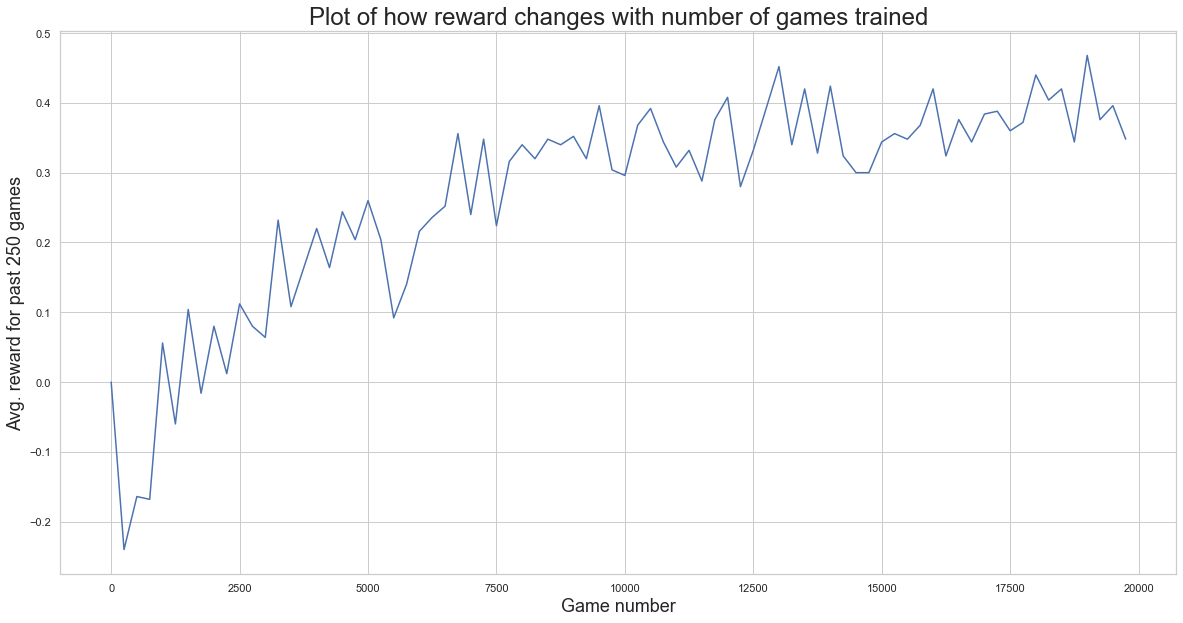

In [5]:
rewards, _, _, _, _ = train(20000, e=0.1)

fig = plt.figure(figsize=(20, 10))
sns.set_theme(style='whitegrid')
X = np.linspace(0, 19750, 20000 // 250)
sns.lineplot(x=X, y=rewards)
plt.title('Plot of how reward changes with number of games trained', fontsize=24)
plt.xlabel('Game number', fontsize=18)
plt.ylabel('Avg. reward for past 250 games', fontsize=18)


### 2.1.1 Decreasing exploration

#### Question 2

In [ ]:
### 2.1.1 Decreasing exploration
# Eight different values of the decrease factors
dec_factors = [1] + [i * 5000 for i in range(1, 9)]
rewards = []

for dec_factor in dec_factors:
    dec_rewards, _, _, _, hist = train(20000, dec_factor=dec_factor, decrease_epsilon=True)
    rewards.append(dec_rewards)

# Expand dims for plotting function
rewards = np.expand_dims(rewards, 1)

In [ ]:
rewards, _, _, _, hist = train(20000, dec_factor=dec_factor, decrease_epsilon=True)

Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000


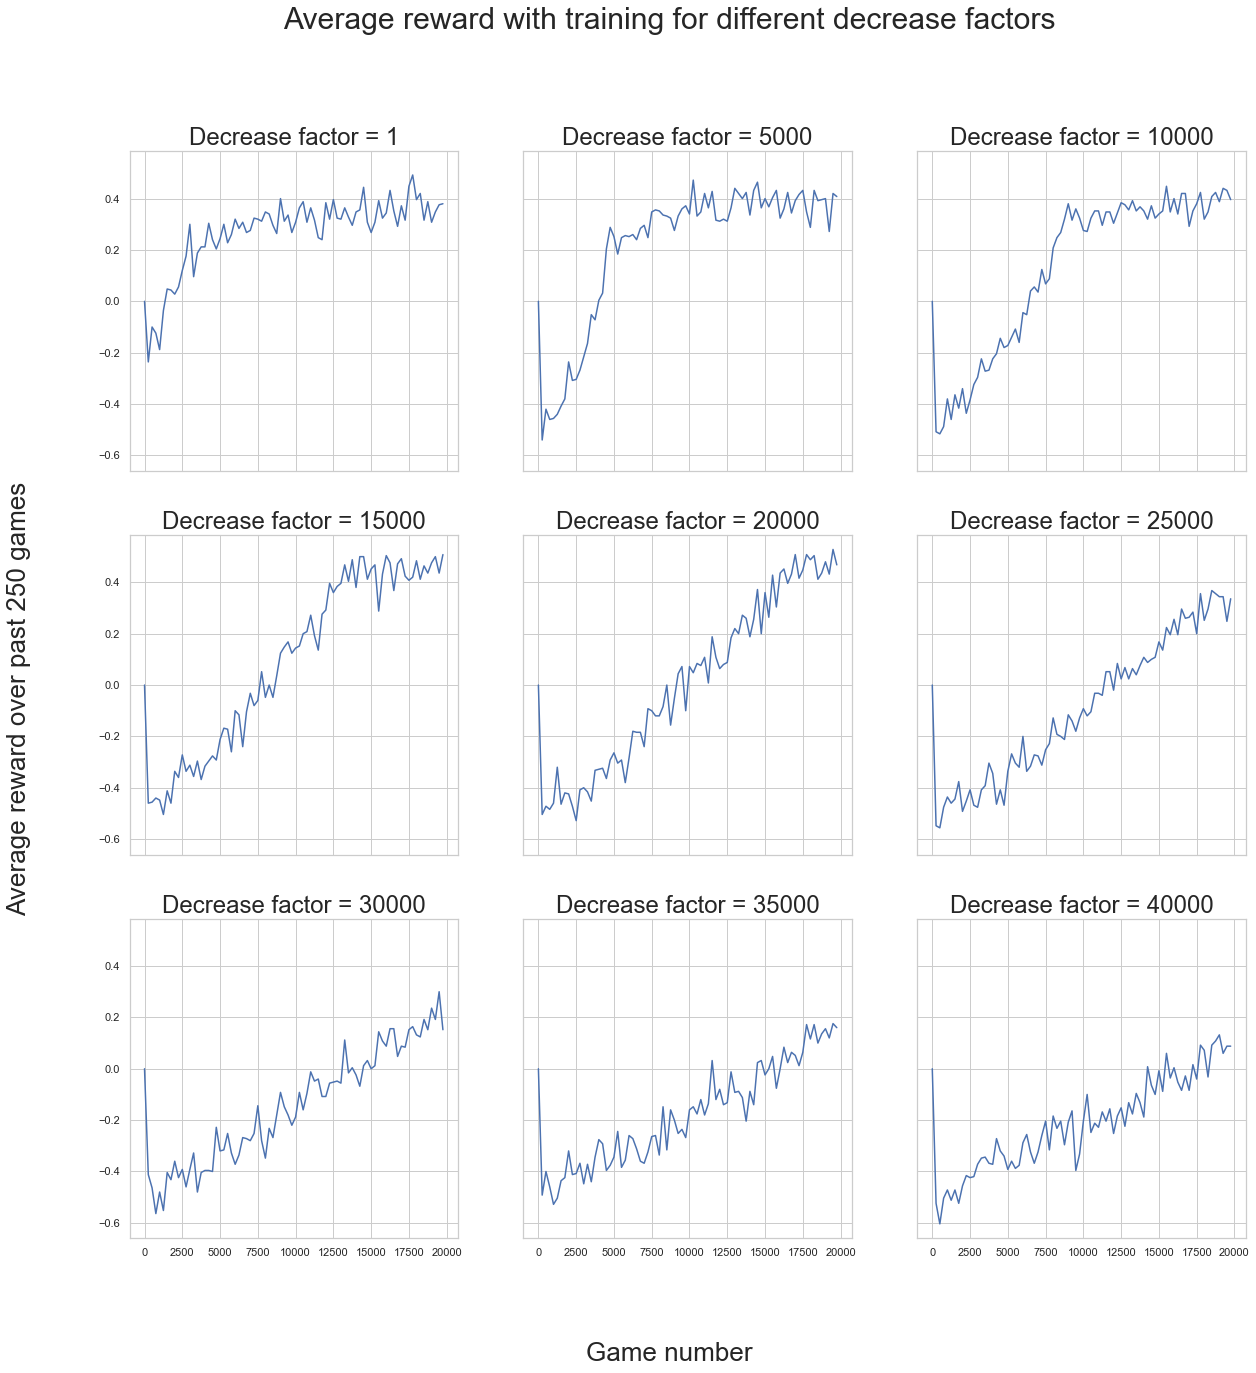

In [ ]:
suptitle = 'Average reward with training for different decrease factors'
subtitle = 'Decrease factor'
xlabel = 'Game number'
ylabel = 'Average reward over past 250 games'
#rewards = np.expand_dims(rewards, 1)
plot_subplots(3, 3, X, rewards, dec_factors, suptitle, 
              xlabel, ylabel, subtitle=subtitle)

The larger $n^*$ is, the longer the algorithm stays in 'exploration' mode, i.e. it will keep a higher value of $\epsilon$ for a longer time. From the plots above it is clear that as $n^*$ grows, the speed of which the algorithm converges slows down. For the $n^* \in [15000, 20000]$, the convergence speed is lower than for the smaller $n^*$, but the eventual reward is larger. 

A correct choice of $\epsilon$ helps training. For the example above, $n^* \in [1, 5000, 10000]$ greatly speeds up training, while $n^* \in [15000, 20000]$ seems to increase convergence treshold. Larger values of $\epsilon$ slows down training, as the algorithm has a higher emphasize on exploration.

#### Question 3

In [ ]:
dec_factors = [1] + [i * 5000 for i in range(1, 9)]
m_opts, m_rands = [], []

for dec_factor in dec_factors:
    _, m_opt, m_rand, _ = train(20000, dec_factor=dec_factor, decrease_epsilon=True, compute_tests=True)
    m_opts.append(m_opt)
    m_rands.append(m_rand)

# Format and stack along axis=1
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)
m = np.hstack([m_opts, m_rands])

Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000


TypeError: _vhstack_dispatcher() got an unexpected keyword argument 'axis'

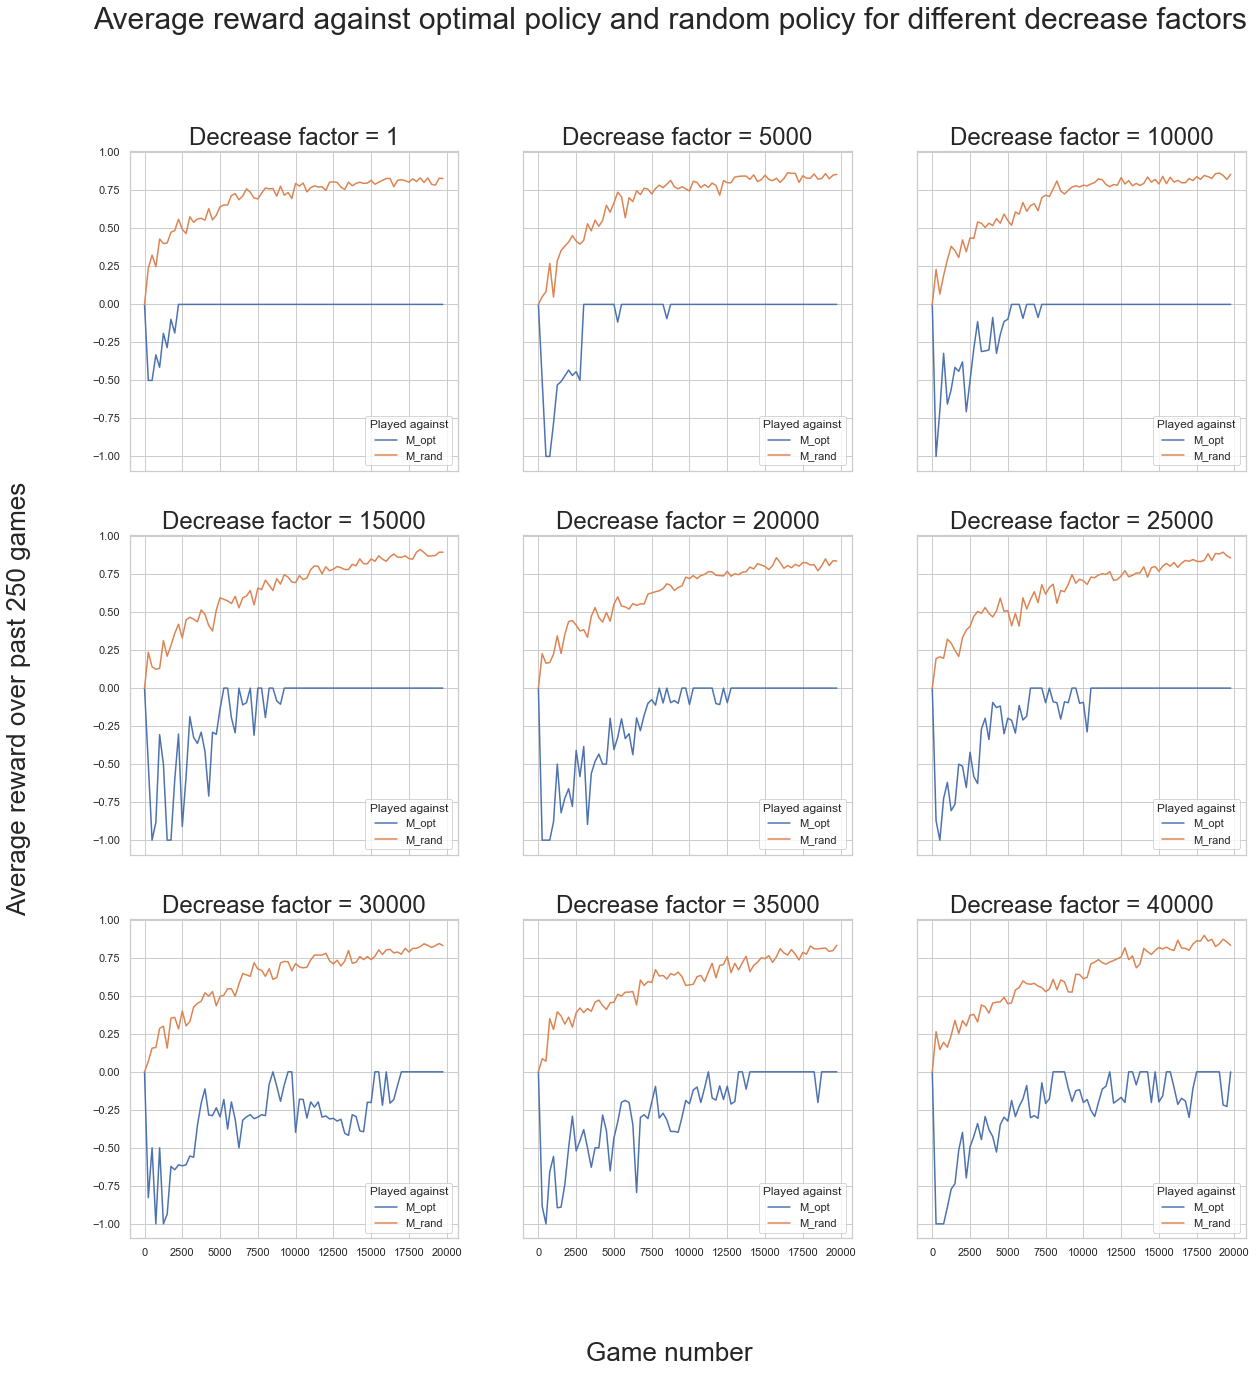

In [ ]:
suptitle = 'Average reward against optimal policy and random policy for different decrease factors'
subtitle = 'Decrease factor'
xlabel = 'Game number'
ylabel = 'Average reward over past 250 games'
plot_subplots(3, 3, X, m, dec_factors, suptitle, xlabel, ylabel, labels=['M_opt', 'M_rand'], 
              legend_title='Played against', subtitle=subtitle)


### 2.1.2 Good experts and bad experts

Choosing $n^*$ = 20000 as this value yields the highest average reward after 20000 games.

We further pick ${\epsilon}_{opt}$ from $[0, 0.1, 0.2, 0.4, 0.6, 0.8]$. 

#### Question 4

In [ ]:
e_opts = [0, 0.1, 0.2, 0.4, 0.6, 0.8]
m_opts, m_rands = [], []

for e_opt in e_opts:
    _, m_opt, m_rand, _ = train(20000, e_opt=e_opt, dec_factor=20000, decrease_epsilon=True, compute_tests=True)
    m_opts.append(m_opt)
    m_rands.append(m_rand)

# Expand dims for stacking
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)

m = np.hstack([m_opts, m_rands])


Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000


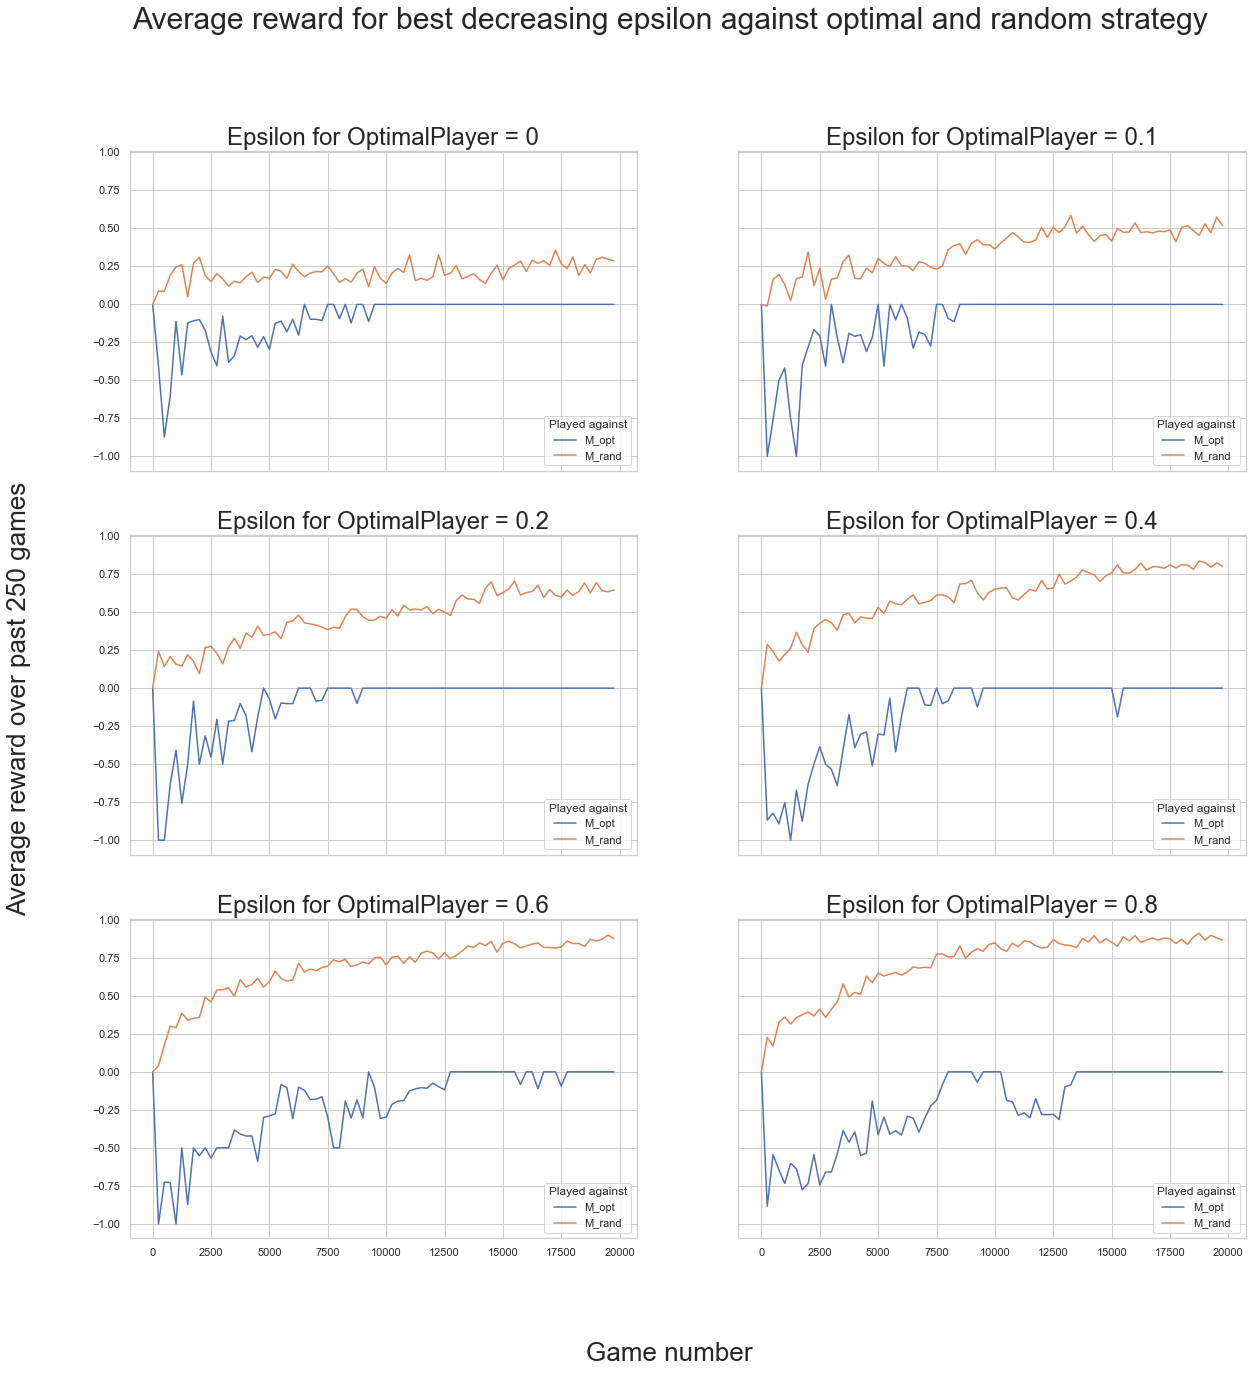

In [ ]:
suptitle = 'Average reward for best decreasing epsilon against optimal and random strategy'
subtitle = 'Epsilon for OptimalPlayer'
xlabel = 'Game number'
ylabel = 'Average reward over past 250 games'
plot_subplots(3, 2, X, m, e_opts, suptitle, xlabel, ylabel,
              labels=['M_opt', 'M_rand'], legend_title='Played against',
              subtitle=subtitle)

#### Question 5

In [ ]:
max_m_opts = np.max(m_opts.reshape((m_opts.shape[0], m_opts.shape[2])))
max_m_rands = np.max(m_rands.reshape((m_rands.shape[0], m_rands.shape[2])))

print('The largest values of M_opt and M_rand are:')
print(f'M_opt: {max_m_opts}')
print(f'M_rand: {max_m_rands}')

The largest values of M_opt and M_rand are:
M_opt: 0.0
M_rand: 0.912


#### Question 6

(Theory) Assume that Agent 1 learns by playing against Opt(0) and find the optimal Q- values Q1(s, a). In addition, assume that Agent 2 learns by playing against Opt(1) and find the optimal Q-values Q2(s, a). Do Q1(s, a) and Q2(s, a) have the same values? Justify your answer. (answer length < 150 words)

Agent 1 and Agent 2 will almost always have different values (or will they eventuelly converge to the same?). Opt(0) will always play an optimal strategy, whereas Opt(1) will play randomly. Therefore, Opt(1) will explore 

#### Question 7

In [ ]:
e_s = [0, 0.25, 0.75, 1]
m_opts, m_rands = [], []

for e in e_s:
    _, m_opt, m_rand, _ = train(20000, e=e, decrease_epsilon=False, compute_tests=True, itself=True)
    m_opts.append(m_opt)
    m_rands.append(m_rand)

# Expand dims for stacking
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)

m = np.hstack([m_opts, m_rands])


Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000
Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000


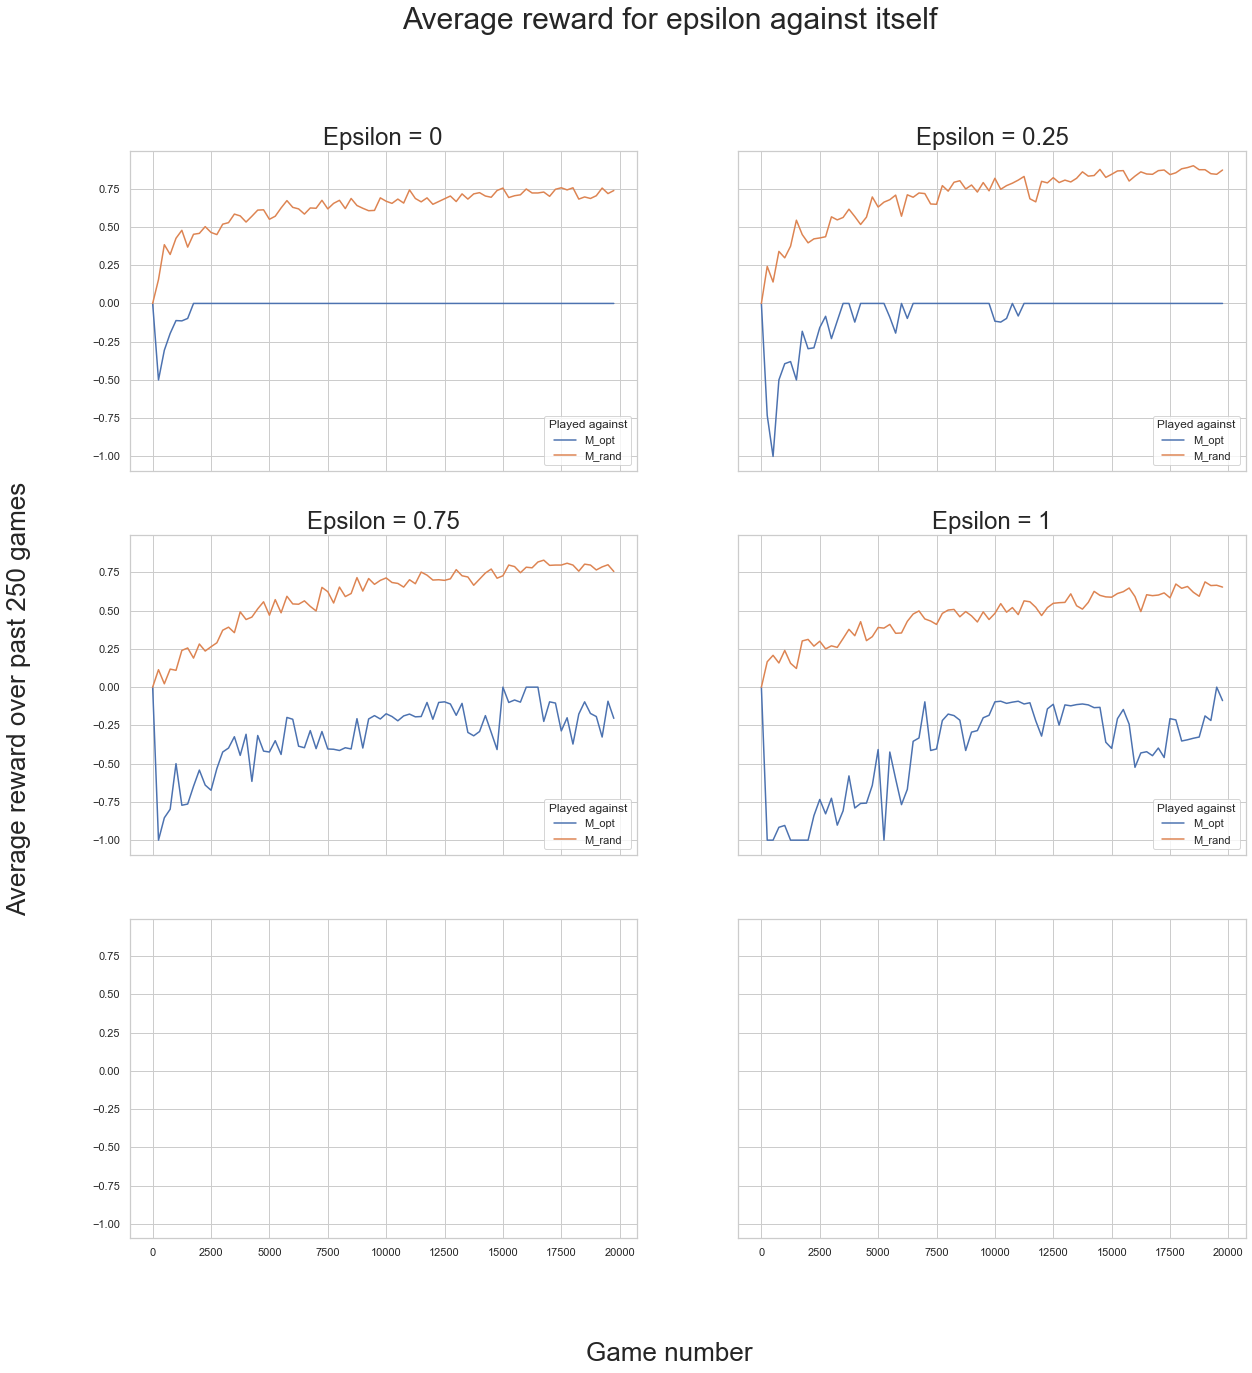

In [ ]:
suptitle = 'Average reward for epsilon against itself'
subtitle = 'Epsilon'
xlabel = 'Game number'
ylabel = 'Average reward over past 250 games'
plot_subplots(2, 2, X, m, e_s, suptitle, xlabel, ylabel,
              labels=['M_opt', 'M_rand'], legend_title='Played against',
              subtitle=subtitle)

#### Question 8

In [ ]:
#TODO: Don't know if this works?
# Why isn't the model capable of learning with decreasing epsilon
#  playing against itself when it is able in Q7?

In [ ]:
dec_factors = [10000]
m_opts, m_rands = [], []

for dec in dec_factors:
    _, m_opt, m_rand, _, Q = train(20000, dec_factor=dec, decrease_epsilon=True, compute_tests=True, itself=True)
    m_opts.append(m_opt)
    m_rands.append(m_rand)

# Expand dims for stacking
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)

m = np.hstack([m_opts, m_rands])
    

Starting game 0
Starting game 5000
Starting game 10000
Starting game 15000


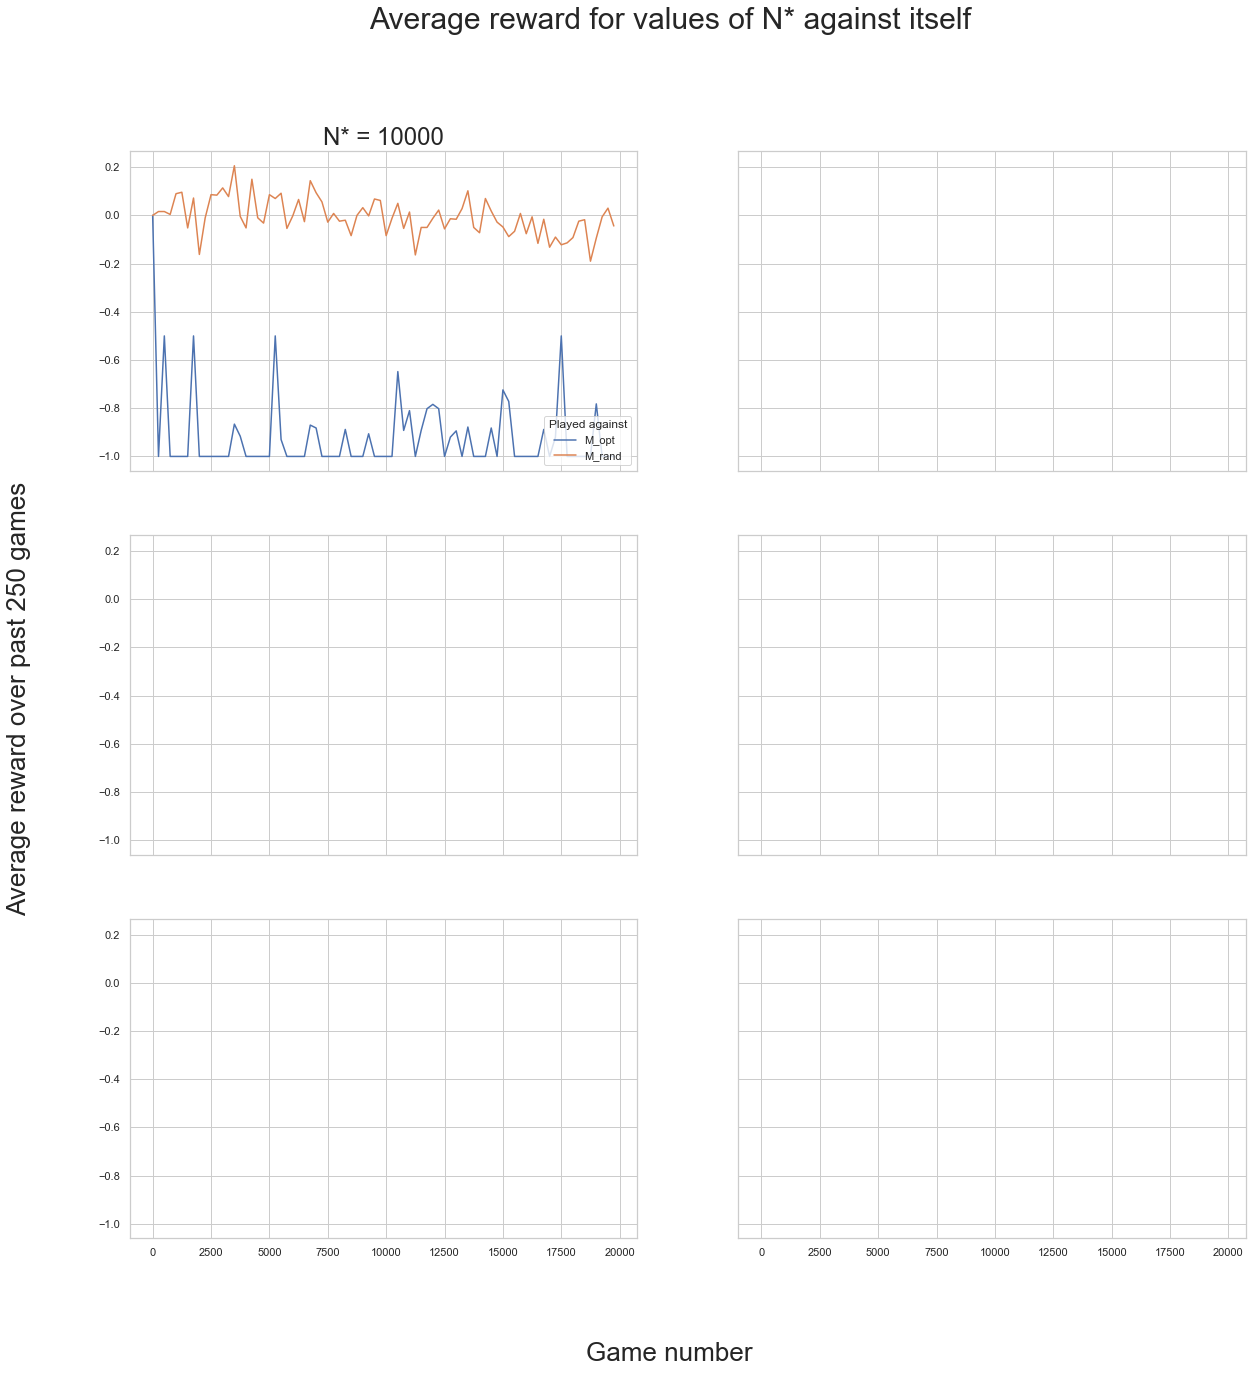

In [ ]:
suptitle = 'Average reward for values of N* against itself'
subtitle = 'N*'
xlabel = 'Game number'
ylabel = 'Average reward over past 250 games'
plot_subplots(3, 2, X, m, dec_factors, suptitle, xlabel, ylabel,
              labels=['M_opt', 'M_rand'], legend_title='Played against',
              subtitle=subtitle)

#### Question 9

In [ ]:
max_m_opts = np.max(m_opts.reshape((m_opts.shape[0], m_opts.shape[2])))
max_m_rands = np.max(m_rands.reshape((m_rands.shape[0], m_rands.shape[2])))

print('The largest values of M_opt and M_rand are:')
print(f'M_opt: {max_m_opts}')
print(f'M_rand: {max_m_rands}')

The largest values of M_opt and M_rand are:
M_opt: 0.0
M_rand: 0.242


#### Question 10

In [ ]:
# Encoding the states we will check out
S1 = TictactoeEnv()
S2 = TictactoeEnv()
S2.step(4); S2.step(0); S2.step(6)
S3 = TictactoeEnv()
S3.step(3); S3.step(4); S3.step(5)
S3.step(2); S3.step(6)

actions = get_legal_moves(S1)
q_values_1 = []
for a in actions:
    q_values_1.append(Q.get(encode(S1,a),0))
q_values_1 = np.asarray(q_values_1)
q_values_1 = q_values_1.reshape((3,3))

#actions = get_legal_moves(S2)
q_values_2 = []
for a in actions:
    q_values_2.append(Q.get(encode(S2,a),0))
q_values_2 = np.asarray(q_values_2)
q_values_2 = q_values_2.reshape((3,3))

#actions = get_legal_moves(S3)
q_values_3 = []
for a in actions:
    q_values_3.append(Q.get(encode(S3,a),0))
q_values_3 = np.asarray(q_values_3)
q_values_3 = q_values_3.reshape((3,3))

Text(0.5, 48.5, '')

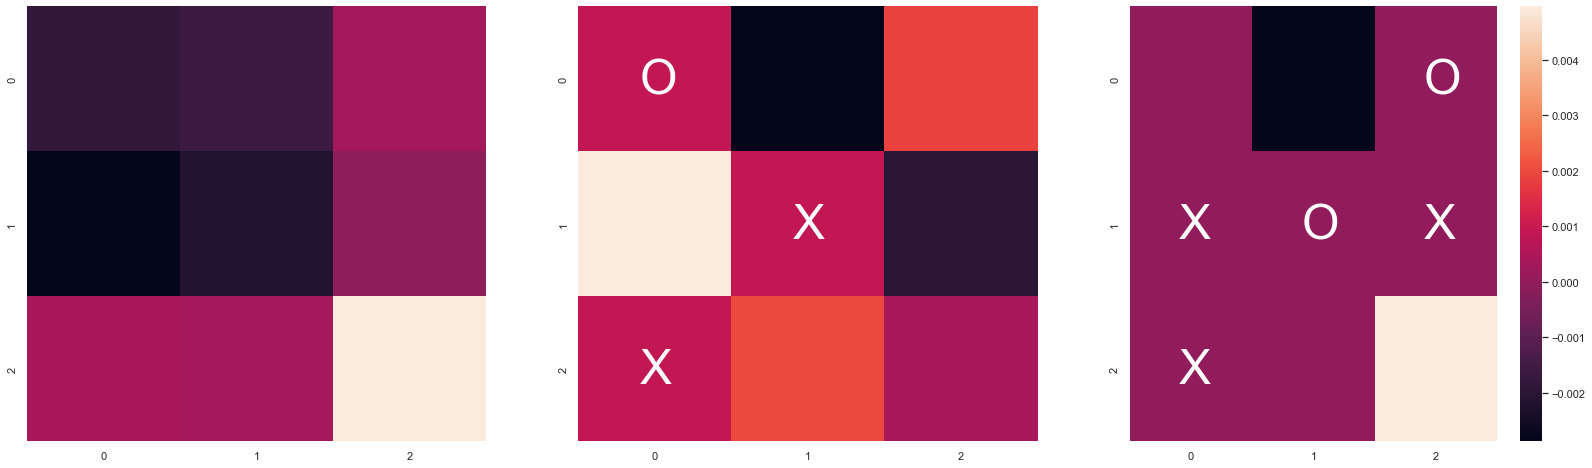

In [ ]:
import seaborn as sns

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(28,8))
g1 = sns.heatmap(q_values_1, cbar=False,ax=ax1)
g1.set_ylabel('')
g1.set_xlabel('')
g2 = sns.heatmap(q_values_2, cbar=False,ax=ax2)
ax2.text(1.4, 1.6, 'X', fontsize=48, color='white')
ax2.text(0.4, 0.6, 'O', fontsize=48, color='white')
ax2.text(0.4, 2.6, 'X', fontsize=48, color='white')
g2.set_ylabel('')
g2.set_xlabel('')
g3 = sns.heatmap(q_values_3, annot=False, annot_kws={'fontsize':'xx-large'}, cbar=True, ax=ax3)
ax3.text(2.4, 1.6, 'X', fontsize=48, color='white')
ax3.text(0.4, 1.6, 'X', fontsize=48, color='white')
ax3.text(0.4, 2.6, 'X', fontsize=48, color='white')
ax3.text(1.4, 1.6, 'O', fontsize=48, color='white')
ax3.text(2.4, 0.6, 'O', fontsize=48, color='white')
g3.set_ylabel('')
g3.set_xlabel('')


## Deep Q-Learning Benjamin

In [14]:
import random
from collections import namedtuple, deque

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('mps')# if torch.backends.mps.is_available() else 'cpu')

BATCH_SIZE = 64 # Take batches of 64
TARGET_UPDATE = 500 # Update every 500 game

In [15]:
print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
# print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
# print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
# device = "mps" if torch.backends.mps.is_available() else "cpu"
# print(f"Using device: {device}")

PyTorch version: 1.10.2+cpu


In [16]:
class DQN(nn.Module):

    def __init__(self):
        super(DQN, self).__init__()
        # Define hidden layers and add Batch Normalization as we're using ReLu
        self.l1 = nn.Linear(in_features=3*3*2, out_features=128)
        #self.bn1 = nn.BatchNorm2d(128)
        self.l2 = nn.Linear(in_features=128, out_features=128)
        #self.bn2 = nn.BatchNorm2d(128)
        self.l3 = nn.Linear(in_features=128, out_features=9)

    def forward(self, x):
        x = x.view(x.shape[0], 3*3*2)
        x = x.to(device)
        # Apply BN before ReLu
        x = F.relu((self.l1(x.float())))
        #x = self.bn1(x)
        x = F.relu((self.l2(x)))
        #x = self.bn2(x)
        x = self.l3(x)
        return x

    # method to take an action given a state
    def act(self, state):
        with torch.no_grad():
            return self.forward(state).max(1)[1].view(1, 1)

In [17]:
# Framework for Replay Memory that stores transitions in games

Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))


class ReplayMemory(object):
    """Copied verbatim from the PyTorch DQN tutorial.
    During training, observations from the replay memory are
    sampled for policy learning.
    """

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

The following function: optimize_model is a direct copy from the Pytorch DQN tutorial. Information can be found here: https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [18]:
def optimize_model(policy_net, target_net, memory, optimizer):
    if len(memory) < BATCH_SIZE:
        return # Do nothing

    # Get batch-array of transitions, and convert to Transition of batch-arrays
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Mask of non-final states
    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)), 
        device=device
    )

    # Non-final states
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    
    # Unpack batch
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Action taken from policy for each state
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute values for next state based on target_net, zero if final
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()


    # Expected Q--values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Huber loss (delta defaults to 1)
    criterion = nn.HuberLoss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))


    # Optimize
    optimizer.zero_grad()
    loss.backward()
    for i, param in enumerate(policy_net.parameters()):
        if param.grad is not None:
            param.grad.data.clamp_(-1, 1)
    optimizer.step()

    return loss.detach()

In [19]:
def select_model_action(
    device: torch.device, model: DQN, state: torch.tensor, eps: float
):
    """Selects an action for the model: either using the policy, or
    by choosing a random valid action (as controlled by `eps`)
    
    Arguments:
        device {torch.device} -- Device
        model {Policy} -- Policy module
        state {torch.tensor} -- Current board state, as a torch tensor
        eps {float} -- Probability of choosing a random state.
    
    Returns:
        Tuple[torch.tensor, bool] -- The action, and a bool indicating whether
                                     the action is random or not.
    """

    sample = random.random()
    if sample > eps:
        return model.act(state)
    else:
        return(
            torch.tensor(
                [[random.randrange(0, 9)]],
                device=device,
                dtype=torch.long,
            ))

In [20]:
def grid2tensor(grid, player = 'X'):
    # if grid is None:
    #     return None
    # Flattened representation of each players positions
    result_p = np.zeros((3, 3))
    result_o = np.zeros((3, 3))
    # Convert player to integer
    player_value = 1 if player == 'X' else -1
    # Retrieve indices of both players positions
    player_mask = np.where(grid == player_value)
    opposition_mask = np.where(grid == - player_value)
    # Insert values into final result
    result_p[player_mask] = 1
    result_o[opposition_mask] = 1
    result = np.array([result_p, result_o])
    # Reshape to shape expected by neural network and convert to tensor
    return torch.from_numpy(result).type(torch.float32)[None]

In [82]:
# We test on policy net, as using the target net would be the same as using
# using the policy net from X iterations backwards
def test_deep(policy_net, rand, e=0):
    ''' Function for computing M_opt and M_rand \n
        Params:
            Q: Learned Q function that maps string representation (S, A) to a float,  dict[string, float] 
            rand: True if calculating M_rand and False if calculating M_opt, boolean
            e: Exploration level, should be zero, int
        Returns: 
            (num_wins - num_losses) / num_games
    '''
    rewards = []
    S = TictactoeEnv()
    for i in range(500): # Fixed number of test games
        np.random.seed(i) # Different seed for each iteration
        # int(False) = 0 => optimal player, else random player
        p = OptimalPlayer(int(rand), 'O') if i % 2 == 0 else OptimalPlayer(int(rand), 'X')
        while not S.end:
            if S.current_player != p.player:
                A = select_model_action(device, policy_net, grid2tensor(S.grid), e)
                A = A.item()
                if not S.check_valid(A):
                    rewards.append(-1)
                    S.reset()
                    break
            else:
                A = p.act(S.grid)

            _, end, _ = S.step(A)
            if end:
                # 1 if policy wins, -1 if policy loses, else 0
                R = - S.reward(player=p.player)
                rewards.append(R)
                S.reset()
                break

    return sum(rewards)  / len(rewards)

def train_deep(N, optimizer, policy_net, target_net, e=0.1, e_opt = 0.5,
            decrease_epsilon=False, dec_factor = 1, memory = ReplayMemory(10000), 
            compute_tests=False, compute_every=250, against_itself=False
            ):

    rewards = []
    losses = []

    curr_rew = []
    curr_loss = []

    m_opts, m_rands = [], []


    Q = {}
    for i in range(N):
        
        S = TictactoeEnv()
        state = grid2tensor(S.grid)
        opt = OptimalPlayer(e_opt, 'O') if i % 2 == 0 else OptimalPlayer(e_opt, 'X')

        if decrease_epsilon:
            e = max(E_MIN, E_MAX*(1 - i / dec_factor))
        
        if compute_tests and i % compute_every == 0:
            m_opt, m_rand = test_deep(policy_net, False), test_deep(policy_net, True)
            m_opts.append(m_opt)
            m_rands.append(m_rand)

        while not S.end:
            if against_itself:
                reward = play_against_itself(S, e, policy_net, memory)
                S.reset()
                break

            if S.current_player != opt.player:
                A = select_model_action(device, policy_net, grid2tensor(S.grid), e)
                valid = S.check_valid(int(A))
                if not valid:
                    end = True
                else:
                    next_state, end, _ = S.step(A.item())

                if not S.end and not end:
                    action_opt = opt.act(S.grid)
                    next_state, _, _ = S.step(action_opt)
            else:
                action_opt = opt.act(S.grid)
                next_state, _, _ = S.step(action_opt)

                # Å kommentere denne vekk tar reward fra 0.2 til ~0.5
                # if not S.end:
                #     A = select_model_action(device, policy_net, grid2tensor(S.grid), e)
                #     valid = S.check_valid(int(A))
                #     if not valid:
                #         end = True
                #     else:
                #         next_state, end, _ = S.step(A.item())
            if S.end or end:
                next_state=None 
                if S.end:
                    reward = -S.reward(player=opt.player)
                else:
                    reward= -1
            else:
                reward = 0
            next_state = grid2tensor(next_state)
            if type(A) is tuple:
                A = A[1]+A[0]*(3)
                A = torch.tensor([[A]], device=device)
            memory.push((state), A, (next_state), torch.tensor([reward], device=device))
            state = next_state
            
        loss = optimize_model(policy_net, target_net, memory, optimizer)
        
        curr_rew.append(reward)
        curr_loss.append(loss)
        
        if i % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if (i%250==0) and i!=0:
            mean_rew = np.asarray([element for element in curr_rew if element!=None]).mean()
            mean_loss = np.asarray([element for element in curr_loss if element!=None]).mean()
            curr_rew = []
            curr_loss = []
            rewards.append(mean_rew)
            losses.append(mean_loss)
        if i%5000 == 0:
            print(i)
    return rewards, losses, m_opts, m_rands

def play_against_itself(S, e, policy_net, memory):
    
    # Init state
    end = False
    flip = True    
    prev_state = grid2tensor(S.grid)
    A = select_model_action(device, policy_net, prev_state, e)
    state, *_ = S.step(A.item())
    state = grid2tensor(state)
    prev_A = A
    A = select_model_action(device, policy_net, state, e)
    
    # Skriver tankene her
    while True:

        if S.check_valid(int(A)):
            next_state, end, winner = S.step(A.item())
            next_state = grid2tensor(next_state)
            if end:
                # Hvis flip er true spiller vi "på andre siden av bordet"
                reward = S.reward('O' if flip else 'X')
                # prev_A ble gjort ved prev_state og ledet til None (next_state)
                # 
                if type(A) is tuple:
                    A = A[1]+A[0]*(3)
                    A = torch.tensor([[A]], device=device)
                if type(prev_A) is tuple:
                    prev_A = prev_A[1]+prev_A[0]*(3)
                    prev_A = torch.tensor([[prev_A]], device=device)
                push_to_memory(memory, prev_state, prev_A, None, -reward, not flip)
                push_to_memory(memory, state, A, None, reward, flip)
                break
        else:
            # Can try with both 1 and 0 as reward for other player when 
            # one player makes an illegal move
            reward = 0
            if type(A) is tuple:
                    A = A[1]+A[0]*(3)
                    A = torch.tensor([[A]], device=device)
            if type(prev_A) is tuple:
                prev_A = prev_A[1]+prev_A[0]*(3)
                prev_A = torch.tensor([[prev_A]], device=device)
            push_to_memory(memory, prev_state, prev_A, None, 0, not flip)
            push_to_memory(memory, state, A, None, -1, flip)
            break # Only get here if one player makes illegal move

        # Push forrige rundes trekk til memory, 
        # og inkrementer tilstanden 
        if type(prev_A) is tuple:
                prev_A = prev_A[1]+prev_A[0]*(3)
                prev_A = torch.tensor([[prev_A]], device=device)
        push_to_memory(memory, prev_state, prev_A, next_state, 0, not flip)
        flip = not flip # Switch player
        prev_A = A
        A = select_model_action(device, policy_net, next_state, e)
        prev_state = state
        state = next_state
        
    return reward

# faen
def push_to_memory(memory, state, A, next_state, reward, flip):
    #print(next_state)
    if flip:
        next = None if next_state is None else torch.flip(next_state, (1, )) 
        memory.push(torch.flip(state, (1, )), A, next, 
                    torch.tensor([reward], device=device))
    else:
        memory.push(state, A, next_state, torch.tensor([reward], device=device))
        

In [83]:
memory = ReplayMemory(10000)

# Creating policy and target networks
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Use Adam optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)

rewards, losses, *_ = train_deep(20000, optimizer, policy_net, target_net)

0
5000
10000
15000


#### Question 11

Text(0, 0.5, 'Average loss')

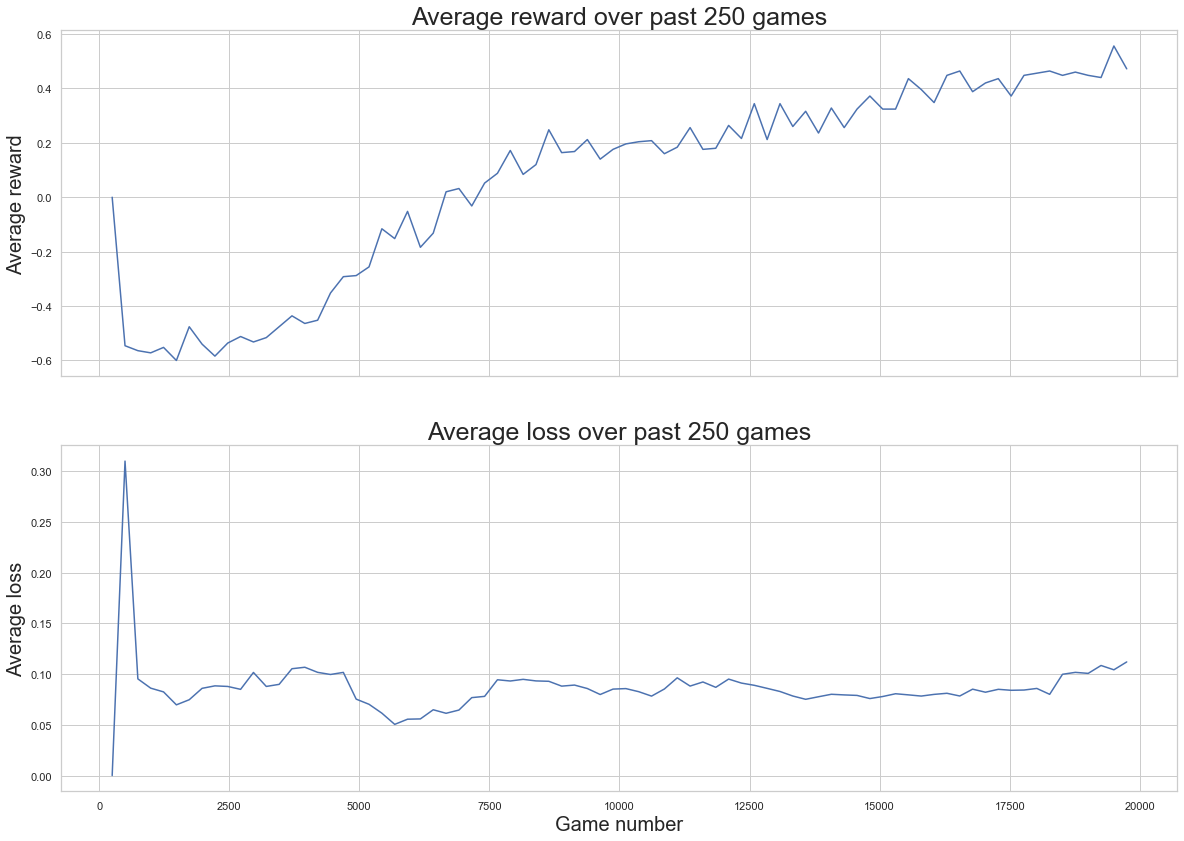

In [262]:
sns.set_theme(style='whitegrid')
fig, axs = plt.subplots(2, 1, figsize=(20, 14), sharex=True)
X = np.linspace(250, 19750, 20000 // 250)
plt.xlabel('Game number', fontsize=20)
plt.ylabel('Avg. reward for past 250 games', fontsize=18)

sns.lineplot(x=X, y=[0]+rewards, ax=axs[0])
sns.lineplot(x=X, y=[0]+losses, ax=axs[1])

axs[0].set_title('Average reward over past 250 games', fontsize=25)
axs[1].set_title('Average loss over past 250 games', fontsize=25)

axs[0].set_ylabel('Average reward', fontsize=20)
axs[1].set_ylabel('Average loss', fontsize=20)

The loss decreases and the agent learns to play Tic Tac Toe

#### Question 12 

In [50]:
memory = ReplayMemory(1)
BATCH_SIZE = 1

# Creating policy and target networks
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

# Use Adam optimizer
optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)

rewards, losses, *_ = train_deep(20000, optimizer, policy_net, target_net, memory = memory)

fig, axs = plt.subplots(2, 1, figsize=(20, 14), sharex=True)
sns.set_theme(style='whitegrid')
X = np.linspace(250, 19750, 20000 // 250)
plt.xlabel('Game number', fontsize=20)
plt.ylabel('Avg. reward for past 250 games', fontsize=18)

sns.lineplot(x=X, y=[0]+rewards, ax=axs[0])
sns.lineplot(x=X, y=[0]+losses, ax=axs[1])

axs[0].set_title('Average reward over past 250 games', fontsize=25)
axs[1].set_title('Average loss over past 250 games', fontsize=25)

axs[0].set_ylabel('Average reward', fontsize=20)
axs[1].set_ylabel('Average loss', fontsize=20)


0


KeyboardInterrupt: 

#### Question 13

In [265]:
BATCH_SIZE = 64

dec_factors = [1, 10000, 20000, 40000]

m_opts = []
m_rands = []

for dec in dec_factors:
    memory = ReplayMemory(10000)
    # Creating policy and target networks
    policy_net = DQN().to(device)
    target_net = DQN().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    # Use Adam optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)

    _, _, dec_m_opts, dec_m_rands = train_deep(
        20000, optimizer, policy_net, target_net, 
        decrease_epsilon=True, dec_factor = dec, memory = memory,
        compute_tests=True
    )
    m_opts.append(dec_m_opts)
    m_rands.append(dec_m_rands)


# Expand dims for stacking
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)

m = np.hstack([m_opts, m_rands])

0
5000
10000
15000
0
5000
10000
15000
0
5000
10000
15000
0
5000
10000
15000


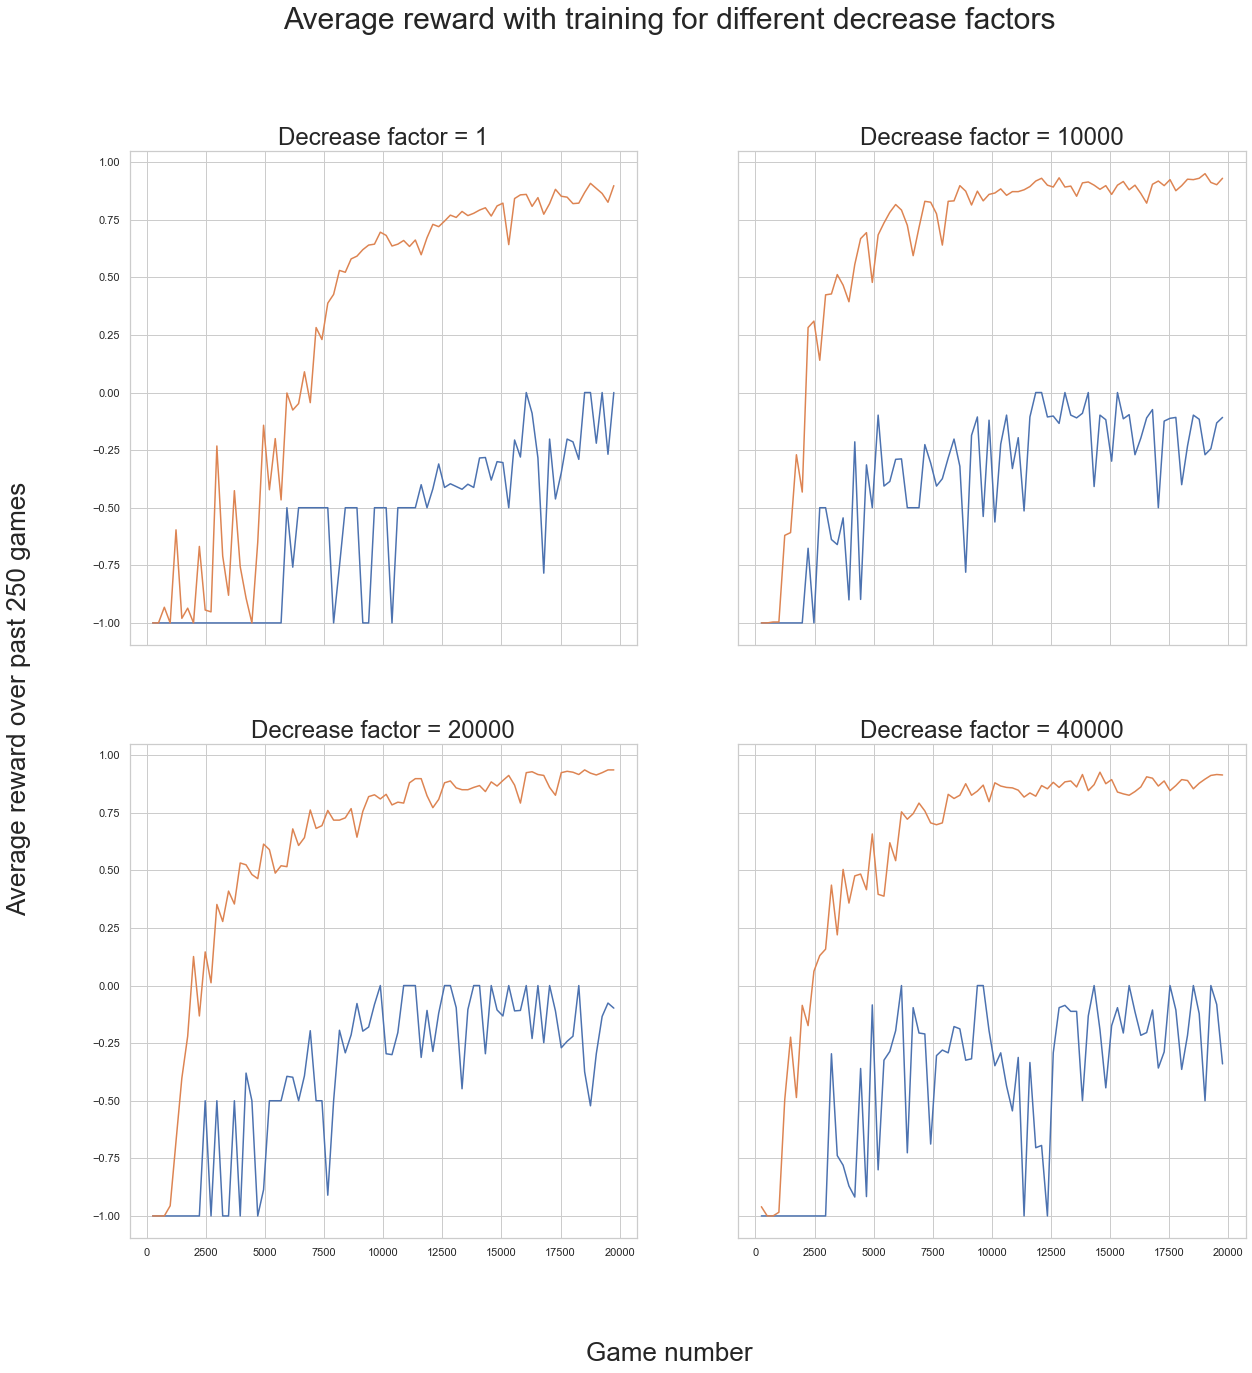

In [266]:
suptitle = 'Average reward with training for different decrease factors'
subtitle = 'Decrease factor'
xlabel = 'Game number'
ylabel = 'Average reward over past 250 games'
#rewards = np.expand_dims(rewards, 1)
plot_subplots(2, 2, X, m, dec_factors, suptitle, 
              xlabel, ylabel, subtitle=subtitle)

TODO: Write something

#### Question 14

In [267]:
e_opts = [0, 0.25, 0.5, 0.75]

m_opts = []
m_rands = []

best_dec_factor = 10000

for e_opt in e_opts:
    memory = ReplayMemory(10000)
    # Creating policy and target networks
    policy_net = DQN().to(device)
    target_net = DQN().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    # Use Adam optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)

    _, _, dec_m_opts, dec_m_rands = train_deep(
        20000, optimizer, policy_net, target_net, 
        decrease_epsilon=True, dec_factor = best_dec_factor, memory = memory,
        compute_tests=True
    )
    m_opts.append(dec_m_opts)
    m_rands.append(dec_m_rands)


# Expand dims for stacking
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)

m = np.hstack([m_opts, m_rands])    

0
5000
10000
15000
0
5000
10000
15000
0
5000
10000
15000
0
5000
10000
15000


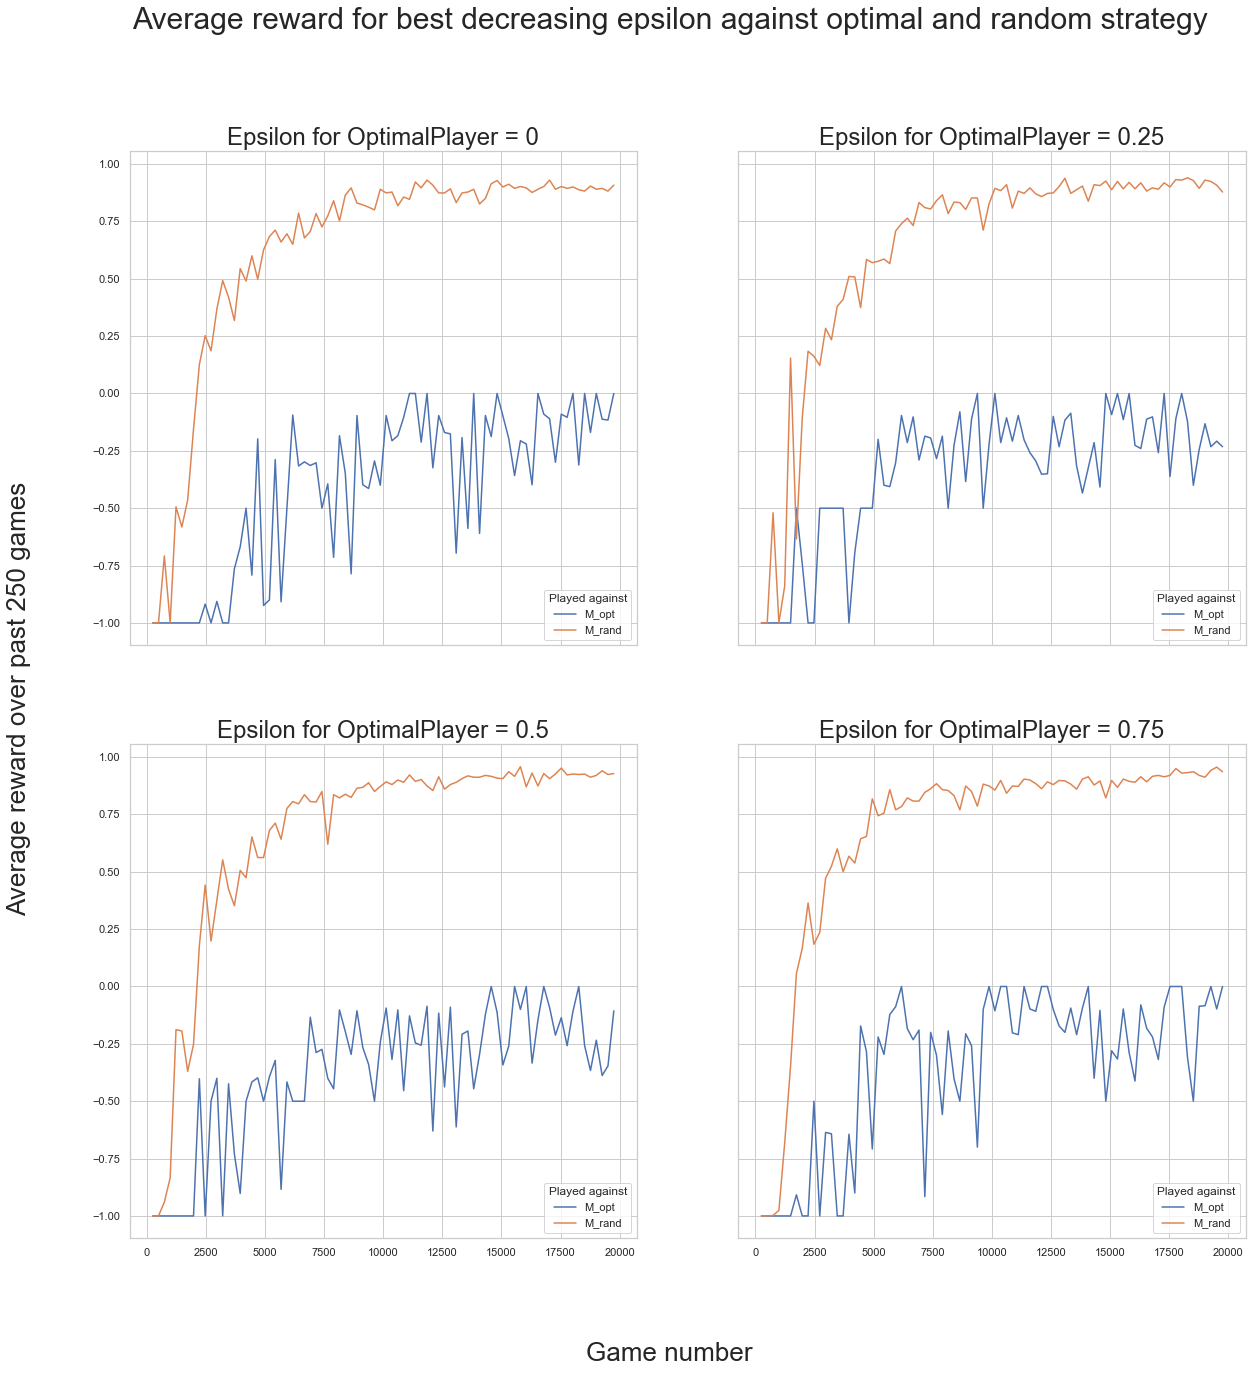

In [268]:
suptitle = 'Average reward for best decreasing epsilon against optimal and random strategy'
subtitle = 'Epsilon for OptimalPlayer'
xlabel = 'Game number'
ylabel = 'Average reward over past 250 games'
plot_subplots(2, 2, X, m, e_opts, suptitle, 
              xlabel, ylabel, labels=['M_opt', 'M_rand'], 
              subtitle=subtitle, legend_title='Played against')

#### Question 15

In [269]:
print(f'After playing 20,000 games, the highest value of M_opt was {np.max(np.ravel(m_opts))},\
        and the highest value of M_rand was {np.max(np.ravel(m_rands))}')

After playing 20,000 games, the highest value of M_opt was 0.0,        and the highest value of M_rand was 0.958


### 3.3 Learning by self-practice

#### Question 16

In [89]:
epsilons = [0.05, 0.25, 0.5, 0.75]
BATCH_SIZE = 64
m_opts = []
m_rands = []

for e in epsilons:
    memory = ReplayMemory(10000)
    # Creating policy and target networks
    policy_net = DQN().to(device)
    target_net = DQN().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    # Use Adam optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)

    _, _, dec_m_opts, dec_m_rands = train_deep(
        20000, optimizer, policy_net, target_net, e=e,
        memory = memory, compute_tests=True, against_itself=True
    )
    m_opts.append(dec_m_opts)
    m_rands.append(dec_m_rands)


# Expand dims for stacking
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)

m = np.hstack([m_opts, m_rands])    

0
5000
10000
15000
0
5000
10000
15000
0
5000
10000


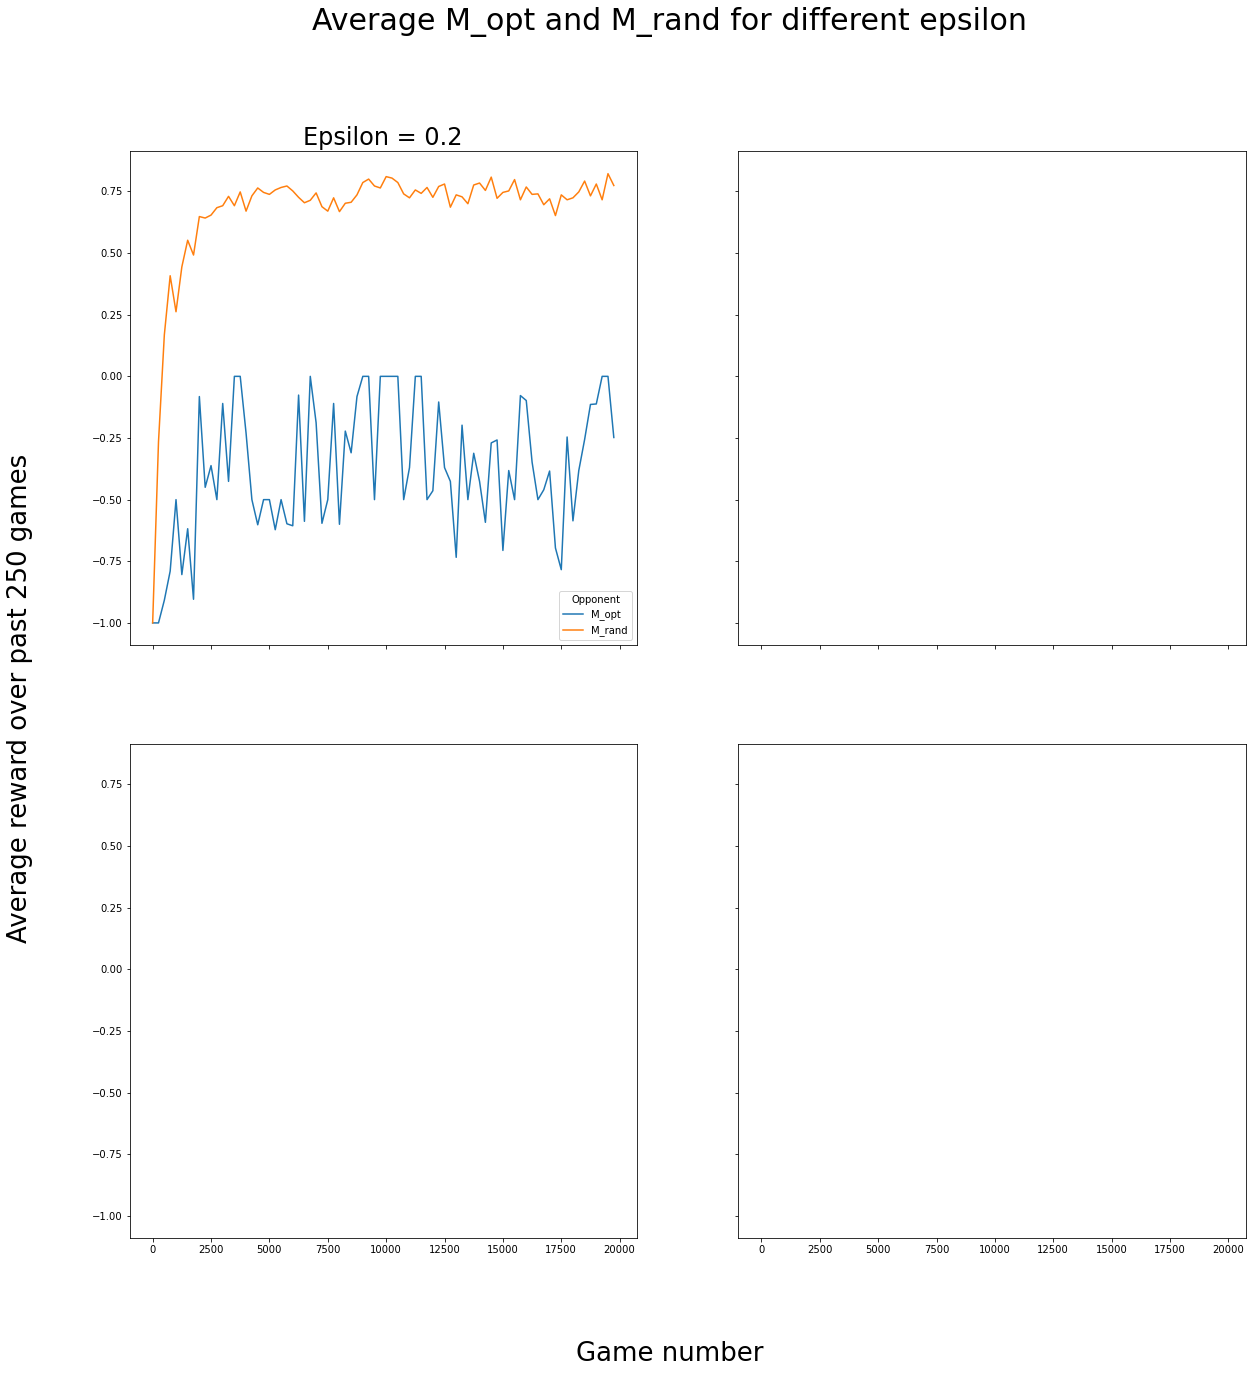

In [ ]:
suptitle = 'Average M_opt and M_rand for different epsilon'
subtitle = 'Epsilon'
xlabel = 'Game number'
ylabel = 'Average reward over past 250 games'
labels = ['M_opt', 'M_rand']
X = np.linspace(0, 19750, 20000 // 250)
plot_subplots(2, 2, X, m, epsilons, suptitle, 
              xlabel, ylabel, subtitle=subtitle,
              labels=labels, legend_title='Opponent')

#### Question 17

In [ ]:
dec_factors = [1, 10000, 20000, 40000]

m_opts = []
m_rands = []

for dec_factor in dec_factors:
    memory = ReplayMemory(10000)
    # Creating policy and target networks
    policy_net = DQN().to(device)
    target_net = DQN().to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    # Use Adam optimizer
    optimizer = optim.Adam(policy_net.parameters(), lr=5e-4)

    _, _, dec_m_opts, dec_m_rands = train_deep(
        20000, optimizer, policy_net, target_net,
        decrease_epsilon=True, dec_factor=dec_factor, 
        memory = memory, compute_tests=True, against_itself=True
    )
    m_opts.append(dec_m_opts)
    m_rands.append(dec_m_rands)


# Expand dims for stacking
m_opts = np.expand_dims(m_opts, 1)
m_rands = np.expand_dims(m_rands, 1)

m = np.hstack([m_opts, m_rands])    

0


/var/folders/jl/2g3c1r312c91xms3bfxxqqdh0000gn/T/ipykernel_9115/2376475031.py:124: RuntimeWarning: Mean of empty slice.
  mean_rew = np.asarray([element for element in curr_rew if element!=None]).mean()
/opt/anaconda3/envs/ann/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/var/folders/jl/2g3c1r312c91xms3bfxxqqdh0000gn/T/ipykernel_9115/2376475031.py:125: RuntimeWarning: Mean of empty slice.
  mean_loss = np.asarray([element for element in curr_loss if element!=None]).mean()


5000
10000
15000
0
5000
10000
15000
0
5000
10000
15000
0
5000
10000
15000


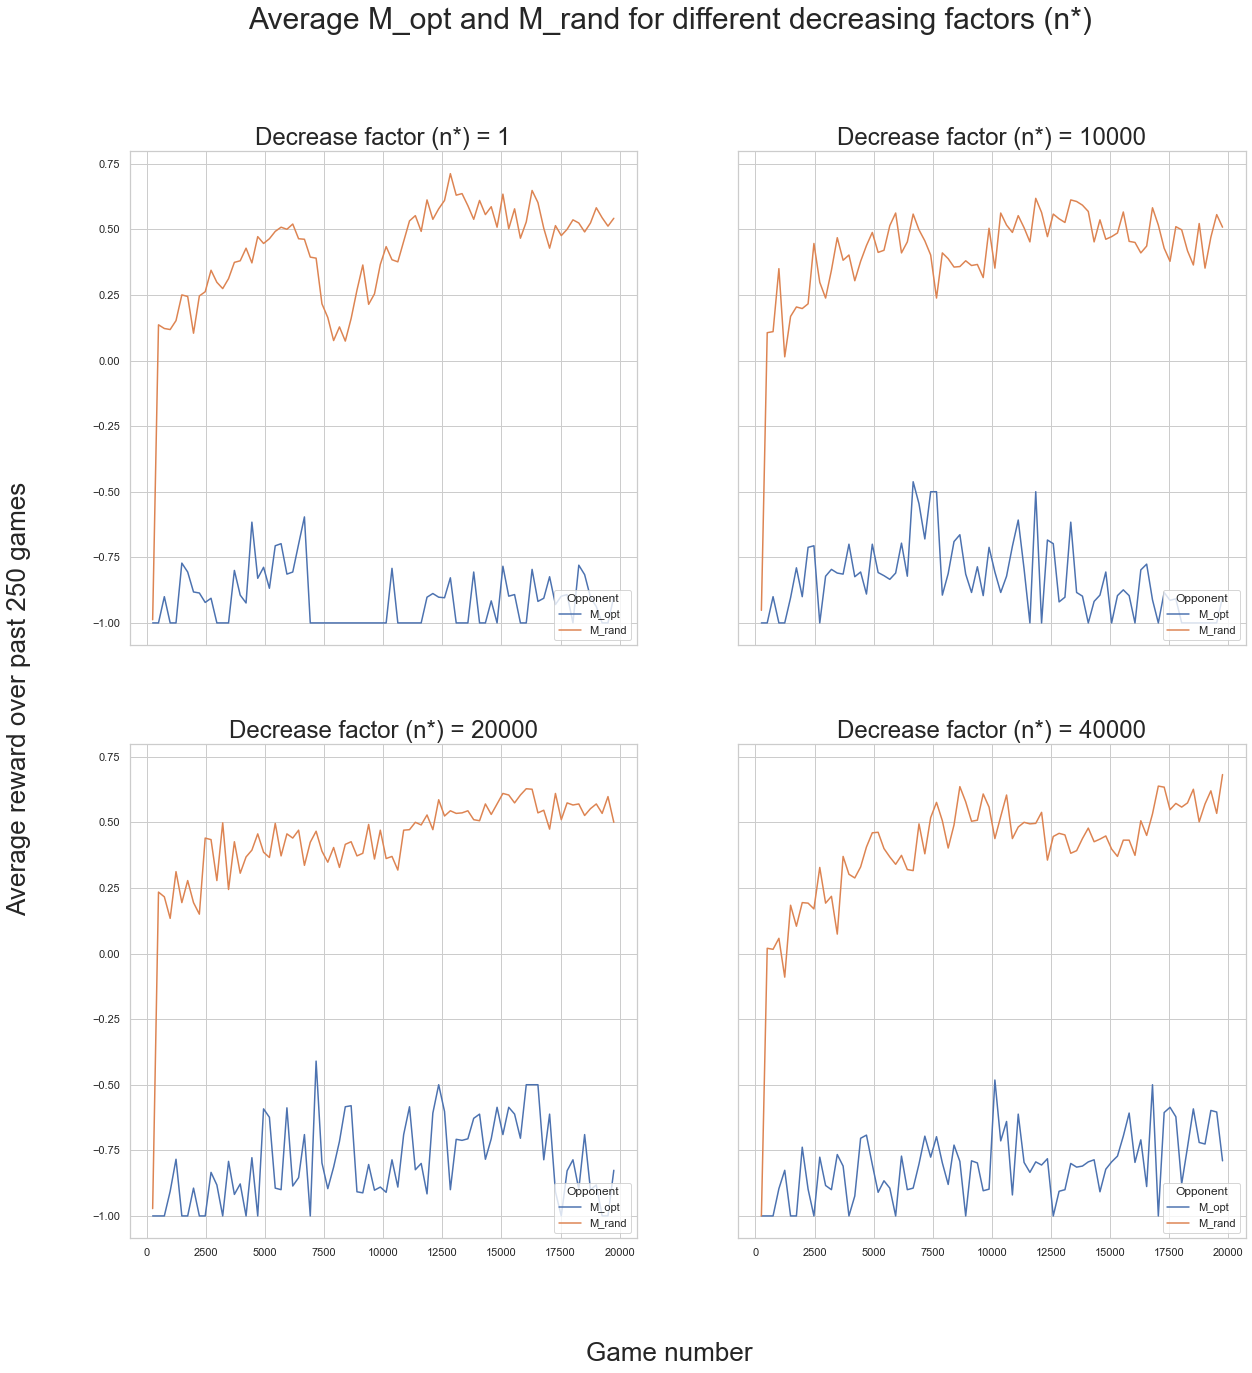

In [ ]:
suptitle = 'Average M_opt and M_rand for different decreasing factors (n*)'
subtitle = 'Decrease factor (n*)'
xlabel = 'Game number'
ylabel = 'Average reward over past 250 games'
labels = ['M_opt', 'M_rand']
plot_subplots(2, 2, X, m, dec_factors, suptitle, 
              xlabel, ylabel, subtitle=subtitle,
              labels=labels, legend_title='Opponent')

#### Question 18

In [ ]:
print(f'After playing 20,000 games, the highest value of M_opt was {np.max(np.ravel(m_opts))},\
        and the highest value of M_rand was {np.max(np.ravel(m_rands))}')

After playing 20,000 games, the highest value of M_opt was -0.41,        and the highest value of M_rand was 0.712


#### Question 19

In [115]:
# TODO: Train policy net with best hyperparameters

Text(0.5, 48.5, '')

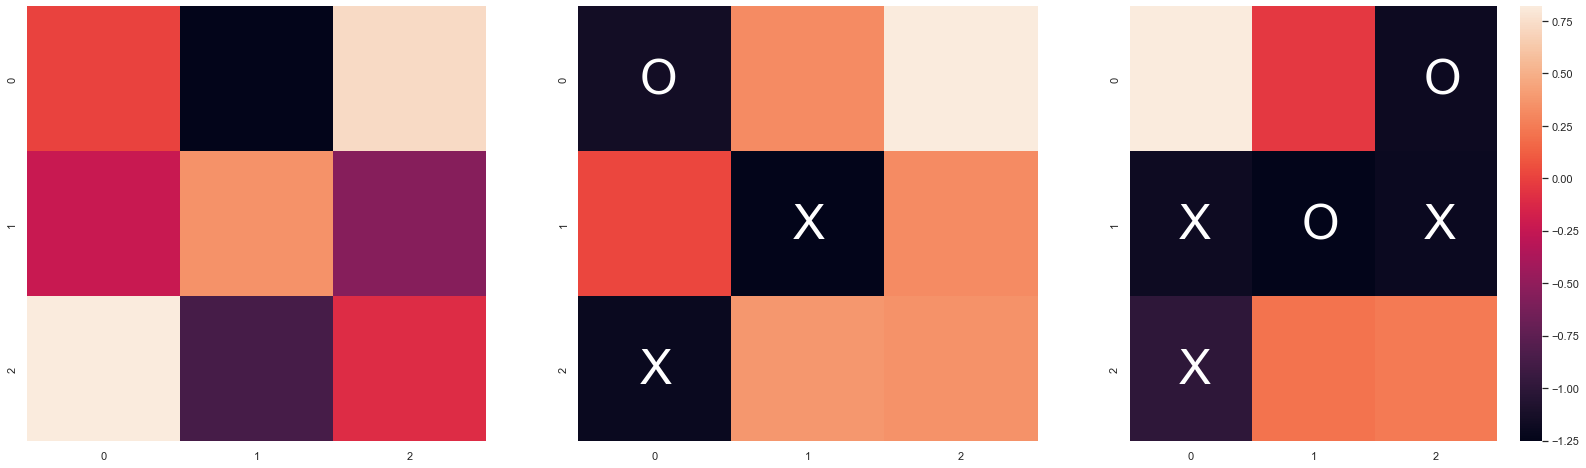

In [118]:
# Encoding the states we will check out (same as in Q10)
S1 = TictactoeEnv()
S2 = TictactoeEnv()
S2.step(4); S2.step(0); S2.step(6)
S3 = TictactoeEnv()
S3.step(3); S3.step(4); S3.step(5)
S3.step(2); S3.step(6)

board1 = grid2tensor(S1.grid)
board2 = grid2tensor(S2.grid)
board3 = grid2tensor(S3.grid)

Q1 = policy_net(board1).detach().numpy().reshape((3, 3))
Q2 = policy_net(board2).detach().numpy().reshape((3, 3))
Q3 = policy_net(board3).detach().numpy().reshape((3, 3))


import seaborn as sns

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(28,8))
g1 = sns.heatmap(Q1, cbar=False, ax=ax1)
g1.set_ylabel(''); g1.set_xlabel('')
g2 = sns.heatmap(Q2, cbar=False,ax=ax2)
ax2.text(1.4, 1.6, 'X', fontsize=48, color='white')
ax2.text(0.4, 0.6, 'O', fontsize=48, color='white')
ax2.text(0.4, 2.6, 'X', fontsize=48, color='white')
g2.set_ylabel(''); g2.set_xlabel('')
g3 = sns.heatmap(Q3, annot=False, annot_kws={'fontsize':'xx-large'}, cbar=True, ax=ax3)
ax3.text(2.4, 1.6, 'X', fontsize=48, color='white')
ax3.text(0.4, 1.6, 'X', fontsize=48, color='white')
ax3.text(0.4, 2.6, 'X', fontsize=48, color='white')
ax3.text(1.4, 1.6, 'O', fontsize=48, color='white')
ax3.text(2.4, 0.6, 'O', fontsize=48, color='white')
g3.set_ylabel(''); g3.set_xlabel('')



## 4 Comparing *Q*-learning witg Deep *Q*-learning

#### Question 20

In [169]:
# Games to reach 80% of final performance, i.e. games to
# reach 80% of the distance from - 1
T_train_opt = np.asarray(m_opts)[2, :, :].reshape(80)
T_train_opt = np.where(T_train_opt >= -1 + 0.8 * (np.max(m_opts[2]) + 1))
T_train_opt[0][0] * 250 # Game number

7000

In [170]:
# Games to reach 80% of final performance, calulcated normally
# as m_rand is positive

T_train_rand = np.asarray(m_rands)[2, :, :].reshape(80)
T_train_rand = np.where(T_train_rand >= 0.8 * np.max(m_rands[2]))
T_train_rand[0][0] * 250 # Game number

11750

In [171]:
# TODO: Calculate best M_opt and M_rand with both deep and normal q-learning